In [2]:
!pip install torchvision==0.16.0
!pip install seaborn
# 安装后点击上方 Restart the kernal

Looking in indexes: http://192.168.2.228:8888/repository/pypi/simple
DEPRECATION: moxing-framework 2.1.16.2ae09d45 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of moxing-framework or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Looking in indexes: http://192.168.2.228:8888/repository/pypi/simple
DEPRECATION: moxing-framework 2.1.16.2ae09d45 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of moxing-framework or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch_npu.contrib import transfer_to_npu
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
# 步骤二：加载数据集
# 2.1 设置参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.01
ACTIVATION = 'relu'   # 可选 'relu' 或 'sigmoid'
OPTIMIZER = 'sgd'     # 可选 'adam' 或 'sgd'
DROPOUT = False
device = 'npu'

# 2.2 数据预处理
transform = transforms.Compose([
    # 请在此处编写代码：ToTensor 和 Normalize
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2.3 加载训练集和测试集
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=transform,
    download=True
)
test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)  # 请在此处编写代码
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)   # 请在此处编写代码

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:11<00:00, 869076.71it/s] 


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 106525.51it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:07<00:00, 227225.72it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2261995.82it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [6]:
# 步骤三：MLP模型的构建
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # 请在此处编写代码：激活函数与Dropout判断
        activation_layer = nn.ReLU() if ACTIVATION == 'relu' else nn.Sigmoid()
        layers = [
            # 请在此处编写代码：Flatten + Linear + activation
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            activation_layer,
        ]
        if DROPOUT:
            # 请在此处编写代码：添加Dropout层
            layers.append(nn.Dropout(0.5))
        layers += [
            # 请在此处编写代码：Linear + activation + output
            nn.Linear(256, 128),
            activation_layer,
            nn.Linear(128, 10)
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

mlp = MLP().to(device)  # 请在此处编写代码：实例化并迁移模型到NPU

In [9]:
# 步骤四：设置损失函数与优化器
criterion = nn.CrossEntropyLoss()  # 请在此处编写代码：交叉熵损失
if OPTIMIZER == 'adam':
    # 请在此处编写代码：Adam优化器
    optimizer = optim.Adam(mlp.parameters(), lr=LR)
elif OPTIMIZER == 'sgd':
    # 请在此处编写代码：SGD优化器
    optimizer = optim.SGD(mlp.parameters(), lr=LR, momentum=0.9)

lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCH
)  # 请在此处编写代码：OneCycleLR调度器

In [10]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []

# 5.1 定义训练函数
def train(epoch):
    mlp.train()
    running_loss = 0.0
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        # 请在此处编写代码：数据迁移，梯度清零
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        # 请在此处编写代码：前向传播，计算loss，反向传播
        outputs = mlp(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # 请在此处编写代码：优化器更新，学习率更新
        optimizer.step()
        lr_scheduler.step()
        # 请在此处编写代码：loss累加与打印
        running_loss += loss.item()
        epoch_loss += loss.item()
        
        if (batch_idx + 1) % 100 == 0:
            print(f"Batch {batch_idx+1}/{len(train_loader)} Loss: {running_loss / 100:.4f}")
            running_loss = 0.0

    # 请在此处编写代码：平均loss并添加到train_losses
    train_losses.append(epoch_loss / len(train_loader))

# 5.2 定义测试函数
def test():
    mlp.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            # 请在此处编写代码：迁移，前向传播，预测
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = mlp(inputs)
            _, predicted = outputs.max(1)
            # 请在此处编写代码：统计正确个数，保存预测和标签
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
            all_preds.append(predicted.cpu())
            all_labels.append(targets.cpu())
    acc = 100.0 * correct / total
    return acc, torch.cat(all_preds), torch.cat(all_labels)

# 5.3 开始训练和测试
os.makedirs('./output', exist_ok=True)
for epoch in range(EPOCH):
    # 请在此处编写代码：调用train函数
    train(epoch)
    if (epoch + 1) % 2 == 0:
        # 请在此处编写代码：调用test函数，记录准确率
        acc, _, _ = test()
        test_accuracies.append(acc)
        print(f"Validation Accuracy after Epoch {epoch+1}: {acc:.2f}%")

Training Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 1/938 [01:13<19:03:13, 73.21s/it]

Training Epoch 1:  12%|█▏        | 113/938 [01:22<00:25, 32.86it/s] 

Batch 100/938 Loss: 2.2125


Training Epoch 1:  22%|██▏       | 209/938 [01:24<00:10, 68.05it/s]

Batch 200/938 Loss: 1.8393


Training Epoch 1:  33%|███▎      | 313/938 [01:25<00:08, 69.46it/s]

Batch 300/938 Loss: 1.1236


Training Epoch 1:  43%|████▎     | 407/938 [01:26<00:07, 71.18it/s]

Batch 400/938 Loss: 0.6640


Training Epoch 1:  54%|█████▍    | 510/938 [01:28<00:06, 69.79it/s]

Batch 500/938 Loss: 0.5020


Training Epoch 1:  65%|██████▌   | 614/938 [01:29<00:04, 69.49it/s]

Batch 600/938 Loss: 0.4116


Training Epoch 1:  76%|███████▌  | 710/938 [01:31<00:03, 69.56it/s]

Batch 700/938 Loss: 0.3609


Training Epoch 1:  86%|████████▌ | 805/938 [01:32<00:01, 67.50it/s]

Batch 800/938 Loss: 0.3358


Training Epoch 1:  97%|█████████▋| 909/938 [01:34<00:00, 69.64it/s]

Batch 900/938 Loss: 0.3151


Training Epoch 1:  99%|█████████▉| 933/938 [01:34<00:00, 69.61it/s]

Training Epoch 1:  99%|█████████▉| 933/938 [01:51<00:00, 69.61it/s]

Training Epoch 2:  12%|█▏        | 112/938 [00:01<00:11, 73.78it/s]

Batch 100/938 Loss: 0.2974


Training Epoch 2:  22%|██▏       | 208/938 [00:03<00:10, 70.22it/s]

Batch 200/938 Loss: 0.2482


Training Epoch 2:  33%|███▎      | 312/938 [00:04<00:09, 67.44it/s]

Batch 300/938 Loss: 0.2482


Training Epoch 2:  43%|████▎     | 408/938 [00:05<00:07, 70.85it/s]

Batch 400/938 Loss: 0.2218


Training Epoch 2:  55%|█████▍    | 512/938 [00:07<00:05, 71.46it/s]

Batch 500/938 Loss: 0.2267


Training Epoch 2:  65%|██████▍   | 608/938 [00:08<00:04, 69.93it/s]

Batch 600/938 Loss: 0.2080


Training Epoch 2:  76%|███████▌  | 711/938 [00:10<00:03, 71.24it/s]

Batch 700/938 Loss: 0.2038


Training Epoch 2:  86%|████████▌ | 806/938 [00:11<00:01, 69.25it/s]

Batch 800/938 Loss: 0.1808


Training Epoch 2:  97%|█████████▋| 910/938 [00:13<00:00, 67.30it/s]

Batch 900/938 Loss: 0.1576


Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Testing:  99%|█████████▊| 155/157 [00:10<00:00, 69.28it/s]

Testing: 100%|██████████| 157/157 [00:25<00:00,  6.07it/s]


Validation Accuracy after Epoch 2: 95.43%


Training Epoch 3:  12%|█▏        | 113/938 [00:01<00:11, 73.08it/s]

Batch 100/938 Loss: 0.1379


Training Epoch 3:  22%|██▏       | 209/938 [00:03<00:09, 73.04it/s]

Batch 200/938 Loss: 0.1577


Training Epoch 3:  33%|███▎      | 313/938 [00:04<00:08, 72.54it/s]

Batch 300/938 Loss: 0.1354


Training Epoch 3:  44%|████▎     | 409/938 [00:05<00:07, 74.10it/s]

Batch 400/938 Loss: 0.1212


Training Epoch 3:  55%|█████▍    | 512/938 [00:07<00:05, 71.98it/s]

Batch 500/938 Loss: 0.1230


Training Epoch 3:  65%|██████▍   | 608/938 [00:08<00:04, 76.48it/s]

Batch 600/938 Loss: 0.1253


Training Epoch 3:  76%|███████▌  | 712/938 [00:09<00:03, 73.58it/s]

Batch 700/938 Loss: 0.1089


Training Epoch 3:  86%|████████▌ | 808/938 [00:11<00:01, 74.01it/s]

Batch 800/938 Loss: 0.1216


Training Epoch 3:  97%|█████████▋| 912/938 [00:12<00:00, 72.02it/s]

Batch 900/938 Loss: 0.1144


Training Epoch 4:  12%|█▏        | 111/938 [00:01<00:11, 70.12it/s]

Batch 100/938 Loss: 0.0907


Training Epoch 4:  22%|██▏       | 207/938 [00:03<00:10, 70.10it/s]

Batch 200/938 Loss: 0.0799


Training Epoch 4:  33%|███▎      | 311/938 [00:04<00:08, 70.31it/s]

Batch 300/938 Loss: 0.0915


Training Epoch 4:  43%|████▎     | 407/938 [00:05<00:07, 70.06it/s]

Batch 400/938 Loss: 0.0932


Training Epoch 4:  54%|█████▍    | 511/938 [00:07<00:06, 68.16it/s]

Batch 500/938 Loss: 0.0919


Training Epoch 4:  65%|██████▍   | 607/938 [00:08<00:04, 69.88it/s]

Batch 600/938 Loss: 0.0787


Training Epoch 4:  76%|███████▌  | 711/938 [00:10<00:03, 73.18it/s]

Batch 700/938 Loss: 0.0851


Training Epoch 4:  86%|████████▌ | 807/938 [00:11<00:01, 68.39it/s]

Batch 800/938 Loss: 0.0777


Training Epoch 4:  97%|█████████▋| 911/938 [00:13<00:00, 68.65it/s]

Batch 900/938 Loss: 0.0837


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.33it/s]


Validation Accuracy after Epoch 4: 97.24%


Training Epoch 5:  12%|█▏        | 112/938 [00:01<00:11, 70.59it/s]

Batch 100/938 Loss: 0.0545


Training Epoch 5:  22%|██▏       | 207/938 [00:03<00:10, 68.81it/s]

Batch 200/938 Loss: 0.0609


Training Epoch 5:  33%|███▎      | 311/938 [00:04<00:09, 69.22it/s]

Batch 300/938 Loss: 0.0607


Training Epoch 5:  43%|████▎     | 407/938 [00:06<00:07, 69.46it/s]

Batch 400/938 Loss: 0.0624


Training Epoch 5:  54%|█████▍    | 511/938 [00:07<00:06, 69.50it/s]

Batch 500/938 Loss: 0.0770


Training Epoch 5:  65%|██████▍   | 607/938 [00:08<00:04, 70.08it/s]

Batch 600/938 Loss: 0.0604


Training Epoch 5:  76%|███████▌  | 711/938 [00:10<00:03, 68.93it/s]

Batch 700/938 Loss: 0.0532


Training Epoch 5:  86%|████████▌ | 807/938 [00:11<00:01, 71.44it/s]

Batch 800/938 Loss: 0.0614


Training Epoch 5:  97%|█████████▋| 911/938 [00:13<00:00, 71.89it/s]

Batch 900/938 Loss: 0.0650


Training Epoch 6:  12%|█▏        | 112/938 [00:01<00:11, 71.51it/s]

Batch 100/938 Loss: 0.0396


Training Epoch 6:  22%|██▏       | 208/938 [00:03<00:09, 73.13it/s]

Batch 200/938 Loss: 0.0390


Training Epoch 6:  33%|███▎      | 312/938 [00:04<00:08, 73.38it/s]

Batch 300/938 Loss: 0.0416


Training Epoch 6:  43%|████▎     | 408/938 [00:05<00:07, 71.44it/s]

Batch 400/938 Loss: 0.0439


Training Epoch 6:  55%|█████▍    | 512/938 [00:07<00:05, 71.18it/s]

Batch 500/938 Loss: 0.0485


Training Epoch 6:  65%|██████▍   | 608/938 [00:08<00:04, 70.54it/s]

Batch 600/938 Loss: 0.0465


Training Epoch 6:  76%|███████▌  | 712/938 [00:10<00:03, 71.62it/s]

Batch 700/938 Loss: 0.0488


Training Epoch 6:  86%|████████▌ | 808/938 [00:11<00:01, 70.99it/s]

Batch 800/938 Loss: 0.0458


Training Epoch 6:  97%|█████████▋| 912/938 [00:12<00:00, 70.11it/s]

Batch 900/938 Loss: 0.0481


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.52it/s]


Validation Accuracy after Epoch 6: 97.74%


Training Epoch 7:  12%|█▏        | 113/938 [00:01<00:11, 70.36it/s]

Batch 100/938 Loss: 0.0321


Training Epoch 7:  22%|██▏       | 209/938 [00:03<00:10, 68.98it/s]

Batch 200/938 Loss: 0.0329


Training Epoch 7:  33%|███▎      | 313/938 [00:04<00:08, 69.56it/s]

Batch 300/938 Loss: 0.0330


Training Epoch 7:  44%|████▎     | 409/938 [00:06<00:07, 69.35it/s]

Batch 400/938 Loss: 0.0276


Training Epoch 7:  55%|█████▍    | 513/938 [00:07<00:06, 69.66it/s]

Batch 500/938 Loss: 0.0274


Training Epoch 7:  65%|██████▍   | 609/938 [00:08<00:04, 70.43it/s]

Batch 600/938 Loss: 0.0289


Training Epoch 7:  76%|███████▌  | 712/938 [00:10<00:03, 71.41it/s]

Batch 700/938 Loss: 0.0401


Training Epoch 7:  86%|████████▌ | 808/938 [00:11<00:01, 71.98it/s]

Batch 800/938 Loss: 0.0327


Training Epoch 7:  97%|█████████▋| 912/938 [00:13<00:00, 70.28it/s]

Batch 900/938 Loss: 0.0338


Training Epoch 8:  12%|█▏        | 112/938 [00:01<00:11, 71.45it/s]

Batch 100/938 Loss: 0.0281


Training Epoch 8:  22%|██▏       | 208/938 [00:03<00:09, 73.49it/s]

Batch 200/938 Loss: 0.0223


Training Epoch 8:  33%|███▎      | 312/938 [00:04<00:08, 73.31it/s]

Batch 300/938 Loss: 0.0201


Training Epoch 8:  43%|████▎     | 408/938 [00:05<00:07, 71.39it/s]

Batch 400/938 Loss: 0.0247


Training Epoch 8:  55%|█████▍    | 512/938 [00:07<00:05, 71.34it/s]

Batch 500/938 Loss: 0.0209


Training Epoch 8:  65%|██████▍   | 608/938 [00:08<00:04, 71.35it/s]

Batch 600/938 Loss: 0.0226


Training Epoch 8:  76%|███████▌  | 712/938 [00:10<00:03, 70.64it/s]

Batch 700/938 Loss: 0.0215


Training Epoch 8:  86%|████████▌ | 808/938 [00:11<00:01, 71.88it/s]

Batch 800/938 Loss: 0.0236


Training Epoch 8:  97%|█████████▋| 912/938 [00:12<00:00, 73.27it/s]

Batch 900/938 Loss: 0.0206


Testing: 100%|██████████| 157/157 [00:02<00:00, 62.12it/s]


Validation Accuracy after Epoch 8: 97.92%


Training Epoch 9:  12%|█▏        | 112/938 [00:01<00:10, 75.10it/s]

Batch 100/938 Loss: 0.0155


Training Epoch 9:  22%|██▏       | 208/938 [00:02<00:10, 72.89it/s]

Batch 200/938 Loss: 0.0202


Training Epoch 9:  33%|███▎      | 312/938 [00:04<00:08, 73.07it/s]

Batch 300/938 Loss: 0.0162


Training Epoch 9:  43%|████▎     | 408/938 [00:05<00:07, 72.59it/s]

Batch 400/938 Loss: 0.0180


Training Epoch 9:  55%|█████▍    | 512/938 [00:07<00:05, 74.37it/s]

Batch 500/938 Loss: 0.0133


Training Epoch 9:  65%|██████▍   | 608/938 [00:08<00:04, 72.85it/s]

Batch 600/938 Loss: 0.0146


Training Epoch 9:  76%|███████▌  | 712/938 [00:09<00:03, 73.92it/s]

Batch 700/938 Loss: 0.0197


Training Epoch 9:  86%|████████▌ | 808/938 [00:11<00:01, 73.28it/s]

Batch 800/938 Loss: 0.0160


Training Epoch 9:  97%|█████████▋| 912/938 [00:12<00:00, 73.06it/s]

Batch 900/938 Loss: 0.0167


Training Epoch 10:  12%|█▏        | 112/938 [00:01<00:11, 71.14it/s]

Batch 100/938 Loss: 0.0145


Training Epoch 10:  22%|██▏       | 208/938 [00:03<00:10, 71.64it/s]

Batch 200/938 Loss: 0.0161


Training Epoch 10:  33%|███▎      | 312/938 [00:04<00:08, 71.23it/s]

Batch 300/938 Loss: 0.0134


Training Epoch 10:  43%|████▎     | 408/938 [00:05<00:07, 72.40it/s]

Batch 400/938 Loss: 0.0133


Training Epoch 10:  55%|█████▍    | 512/938 [00:07<00:05, 73.30it/s]

Batch 500/938 Loss: 0.0125


Training Epoch 10:  65%|██████▍   | 608/938 [00:08<00:04, 71.84it/s]

Batch 600/938 Loss: 0.0126


Training Epoch 10:  76%|███████▌  | 712/938 [00:10<00:03, 72.26it/s]

Batch 700/938 Loss: 0.0143


Training Epoch 10:  86%|████████▌ | 808/938 [00:11<00:01, 73.97it/s]

Batch 800/938 Loss: 0.0139


Training Epoch 10:  97%|█████████▋| 912/938 [00:12<00:00, 73.99it/s]

Batch 900/938 Loss: 0.0126


Testing: 100%|██████████| 157/157 [00:02<00:00, 59.50it/s]


Validation Accuracy after Epoch 10: 98.08%


Testing: 100%|██████████| 157/157 [00:02<00:00, 65.36it/s]



Final Test Accuracy: 98.08%


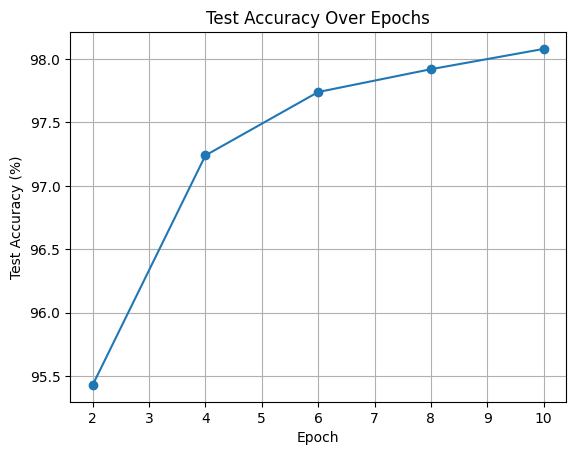

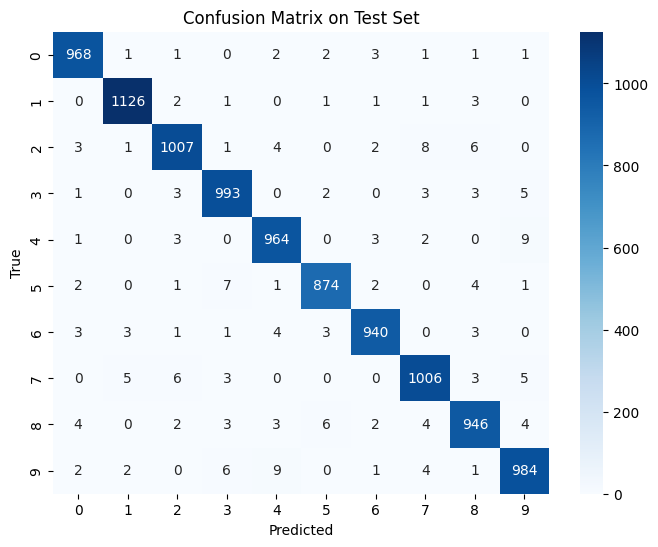

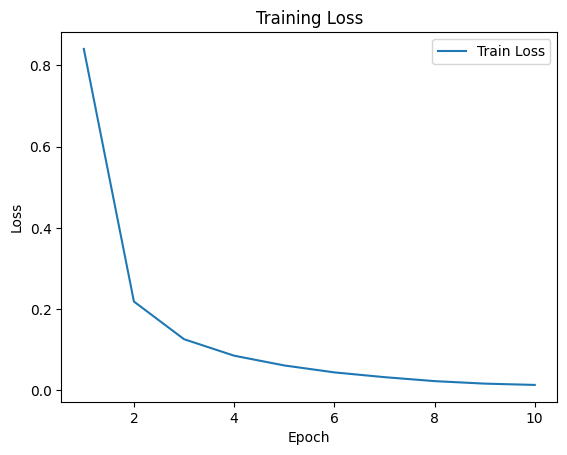

********Prediction Samples********
Predicted labels: [7 2 1 0 4 1 4 9 5 9]
Actual labels:    [7 2 1 0 4 1 4 9 5 9]


In [11]:
# 步骤六：模型评估
# 6.1 最后一次完整测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# 6.2 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(2, EPOCH+1, 2), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.savefig('./output/accuracy_curve.png')
plt.show()

# 6.3 绘制混淆矩阵
conf_mat = confusion_matrix(true_y, pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.4 绘制训练 loss 曲线图
plt.figure()
plt.plot(range(1, EPOCH+1, 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('./output/loss_curve.png')
plt.show()

# 6.5 打印前10个样本预测
print('********Prediction Samples********')
print("Predicted labels:", pred_y[:10].numpy())
print("Actual labels:   ", true_y[:10].numpy())

In [12]:
# 步骤七：保存模型
# 请在此处编写代码：保存模型
torch.save(mlp.state_dict(), './output/mlp_mnist_npu.pth')
print("\nModel saved at ./output/mlp_mnist_npu.pth")


Model saved at ./output/mlp_mnist_npu.pth


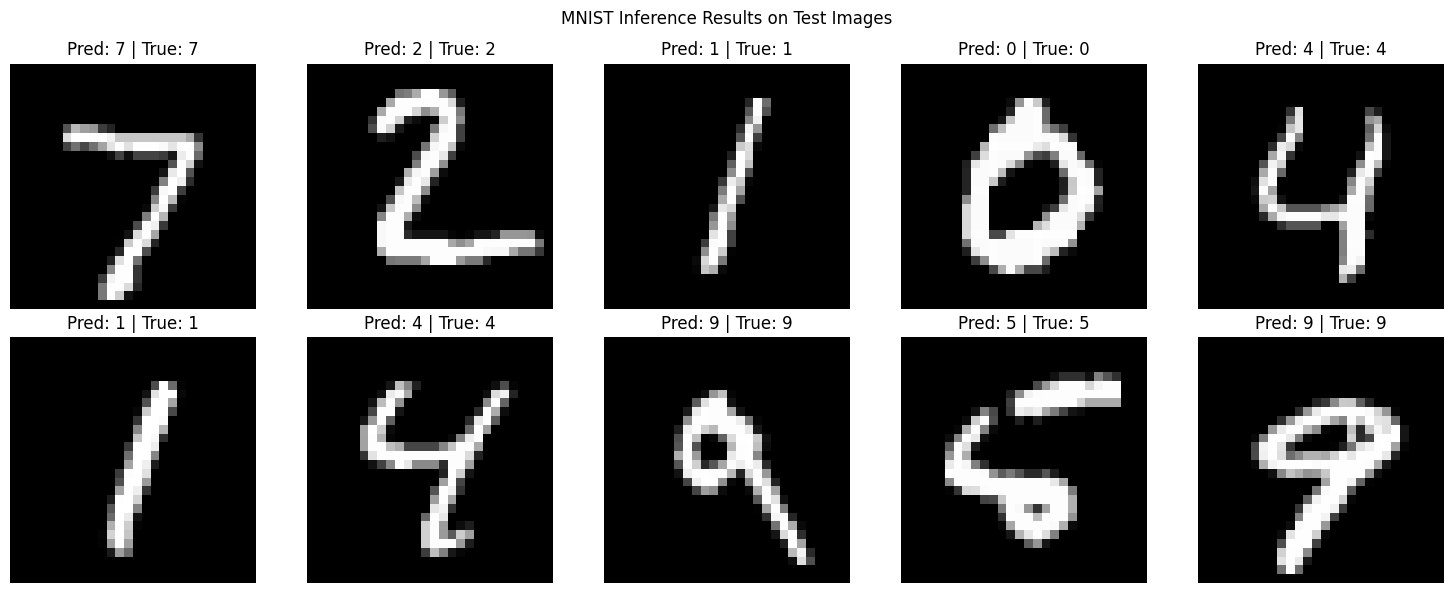

In [13]:
# 步骤八：推理结果可视化（MNIST专用）
def visualize_mnist_predictions(model, test_loader, device='cpu', num_images=10):
    """
    可视化模型在 MNIST 测试集上的部分预测结果（灰度图）
    """
    # 请在此处编写代码：切换模型为eval模式
    model.eval()
    shown = 0
    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for inputs, targets in test_loader:
            # 请在此处编写代码：将inputs和targets迁移到设备
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # 请在此处编写代码：前向传播
            _, predicted = outputs.max(1)  # 请在此处编写代码：获取预测类别

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break

                img = inputs[i].cpu().squeeze().numpy()  # 请在此处编写代码：获取第i张图像并转为(28,28) numpy格式
                true_label = targets[i].cpu().item()  # 请在此处编写代码：获取真实标签
                pred_label = predicted[i].cpu().item()  # 请在此处编写代码：获取预测标签

                plt.subplot(2, (num_images + 1) // 2, shown + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"Pred: {pred_label} | True: {true_label}")
                plt.axis('off')
                shown += 1

            if shown >= num_images:
                break

    plt.suptitle("MNIST Inference Results on Test Images")
    plt.tight_layout()
    plt.savefig('./output/mnist_test_predictions.png')
    plt.show()


# 调用推理可视化函数
visualize_mnist_predictions(mlp, test_loader, device=device, num_images=10)